# MNIST Hand-Written Dataset Training & Adjustments to FPGA

In [1]:
import tensorflow as tf
import functools
import numpy as np
import sys
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from keras.datasets import mnist

## This part is for weight generation --DO NOT RUN THE CELLS BELOW IF YOU HAVE ALREADY RUN ONCE--

In [4]:
#train_image_f = gzip.open("C:/Users/zzyzz/train_images.gz", "rb")
#train_image = train_image_f.read()
#print(train_image.shape)

#Load data from MNIST dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
(train1X, train1Y), (test1X, test1Y)= mnist.load_data()
#Reshape and noemalize the training and test set images
trainX = trainX.reshape(60000, 784).astype("float32") / 255
testX = testX.reshape(10000, 784).astype("float32") / 255
trainy = trainy.astype("float32")
testy = testy.astype("float32")

# Reserve 10,000 samples for validation
valX = trainX[-10000:]
valy = trainy[-10000:]
trainX = trainX[:-10000]
trainy = trainy[:-10000]


# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
print(valX.shape)
print(valy.shape)

Train: X=(50000, 784), y=(50000,)
Test: X=(10000, 784), y=(10000,)
(10000, 784)
(10000,)


In [5]:
hiddel_size = 64
output_size = 10

inputs = tf.keras.layers.Input(shape=(784,), name="digits")
hidden = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
#x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="predictions")(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epoch = 10
num_batch = 128

print("Fit model on training data")
history = model.fit(
    trainX,
    trainy,
    batch_size=num_batch,
    epochs=num_epoch,
    validation_data=(valX, valy),
)

Fit model on training data
Epoch 1/10
391/391 [==============================] - 0s 883us/step - loss: 0.4569 - accuracy: 0.8746 - val_loss: 0.2467 - val_accuracy: 0.9332
Epoch 2/10
391/391 [==============================] - 0s 635us/step - loss: 0.2353 - accuracy: 0.9331 - val_loss: 0.1948 - val_accuracy: 0.9489
Epoch 3/10
391/391 [==============================] - 0s 629us/step - loss: 0.1861 - accuracy: 0.9463 - val_loss: 0.1614 - val_accuracy: 0.9554
Epoch 4/10
391/391 [==============================] - 0s 642us/step - loss: 0.1522 - accuracy: 0.9562 - val_loss: 0.1487 - val_accuracy: 0.9578
Epoch 5/10
391/391 [==============================] - 0s 624us/step - loss: 0.1299 - accuracy: 0.9629 - val_loss: 0.1294 - val_accuracy: 0.9644
Epoch 6/10
391/391 [==============================] - 0s 625us/step - loss: 0.1122 - accuracy: 0.9678 - val_loss: 0.1211 - val_accuracy: 0.9660
Epoch 7/10
391/391 [==============================] - 0s 623us/step - loss: 0.0985 - accuracy: 0.9713 - val_l

In [8]:
results = model.evaluate(testX, testy, batch_size=128)
predictions = model.predict(testX[:3])

79/79 [==============================] - 0s 398us/step - loss: 0.1001 - accuracy: 0.9708


## Result Extraction

In [9]:
w1 = model.layers[1].get_weights()[0]
w2 = model.layers[2].get_weights()[0]
print("w1: shape")
print(w1.shape)
print("w2: shape")
print(w2.shape)

w1: shape
(784, 64)
w2: shape
(64, 10)


In [15]:
#write weights into files
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)
f = open("weight1.txt", "w")
f.write("w1: shape\n")
f.write(str(w1.shape))
f.write("\n")
f.write(str(w1))
f.write("\n\n")
f.close()
f = open("weight2.txt", "w")
f.write("w2: shape\n")
f.write(str(w2.shape))
f.write("\n\n")
f.write(str(w2))
f.close()

np.set_printoptions(threshold=None)

In [16]:



#w1h = float_to_hex(w1)
#w2h = float_to_hex(w2)

## Result Verification

In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
def relu(X):
    return np.maximum(0,X)

In [18]:
import matplotlib.pyplot as plt

3


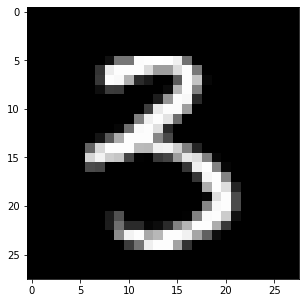

In [19]:
#test1X=data, test1Y=label
plt.figure(figsize=(5, 5))

index = 5000 # index from 0 to 9999

(test_img, test_label) = (test1X[index].astype("float32") / 255, test1Y[index])
plt.imshow(test_img, interpolation='nearest', cmap=plt.get_cmap('gray'))
print(test_label)

In [20]:
test_img = test_img.reshape(784)
print(test_img.shape)
print(w1.shape)

(784,)
(784, 64)


In [21]:
test_hidden = np.dot(test_img, w1)
test_hidden = relu(test_hidden)
print(test_hidden.shape)
test_out = np.dot(test_hidden, w2)
test_out = softmax(test_out)
print(test_out)
print(np.argmax(test_out, 0))

(64,)
[0.00000253 0.0000018  0.00000237 0.99949    0.00002136 0.00010635
 0.00000002 0.00000414 0.00025353 0.00011789]
3


In [22]:
def mat_mul(A, B):
    result = np.zeros(B.shape[1]) # final result
    for i in range(B.shape[1]): #1-64 (B.shape[0]=784, B.shape[1]=64)
        product = 0
        for j in range(A.size): #1-784
            product += A[j] * B[j][i]
        result[i] = product
    return(result)

In [23]:
print(w1.shape[1])
print(test_img.size)

64
784


In [24]:
print(test_img.shape)
test_hidden = mat_mul(test_img, w1)
test_hidden = relu(test_hidden)
print(test_hidden.shape)
test_out = mat_mul(test_hidden, w2)
test_out = softmax(test_out)
print(test_out)
print(np.argmax(test_out, 0))

(784,)
(64,)
[0.00000253 0.0000018  0.00000237 0.99949    0.00002136 0.00010635
 0.00000002 0.00000414 0.00025353 0.00011789]
3


In [25]:
print(test_img.shape)
print(w1.shape)


(784,)
(784, 64)


## Save the Result as Binary File

Already done it. Don't run again.

In [26]:
#save as binary file
w1b = bytearray(w1)
w2b = bytearray(w2)
f = open("weight1.bin", "wb")
f.write(w1b)
f.close()
f = open("weight2.bin", "wb")
f.write(w2b)
f.close()

Read Test

In [28]:
import struct
from array import array
import os

In [29]:
os.path.getsize('weight1.bin')

200704

In [31]:
np.savetxt('weight1.dat', w1, fmt = '%.10f')
np.savetxt('weight2.dat', w2, fmt = '%.10f')

# Write the data in hex format

In [62]:
def float_to_hex(f):
    return int(struct.unpack('<I', struct.pack('<f', f))[0])
print(float_to_hex(17.5)) #print float number in hex format without '0x'

1099694080


In [100]:
# convert the floating point into int format
w1_hex = np.zeros(w1.shape).astype(str)
for i in range(w1.shape[0]):
    for j in range(w1.shape[1]):
        w1_hex[i][j] = format(float_to_hex(w1[i][j]),'x')
w2_hex = np.zeros(w2.shape).astype(str)
for i in range(w2.shape[0]):
    for j in range(w2.shape[1]):
        w2_hex[i][j] = format(float_to_hex(w2[i][j]),'x')
#print(format(w1_hex[0][0],'x'))

In [85]:
print(w1.shape)
f = open("weight1_hex.dat", "w")
for i in range(w1.shape[0]):
    for j in range(w1.shape[1]):
        f.write(format(w1_hex[i][j],'x'))
        f.write(" ")
    f.write("\n")
f.write("\n")
f.close()
print(w2.shape)
f = open("weight2_hex.dat", "w")
for i in range(w2.shape[0]):
    for j in range(w2.shape[1]):
        f.write(format(w2_hex[i][j],'x'))
        f.write(" ")
    f.write("\n")
f.write("\n")
f.close()

(784, 64)
(64, 10)


# Write the data into csv

In [101]:
import pandas as pd

df1 = pd.DataFrame(w1_hex)
df1.to_csv('weight1_hex.csv')
df2 = pd.DataFrame(w2_hex)
df2.to_csv('weight2_hex.csv')
df3 = pd.DataFrame(w1)
df3.to_csv('weight1.csv')
df4 = pd.DataFrame(w2)
df4.to_csv('weight2.csv')